# **Insper - Eletromagnetismo e Ondulatória** #


**Repelente elétrico acionado por transmissão de energia sem fio**

Desenvolvido por: 
- Caue Pileckas D Agostinho
- Enzo Davi Ribeiro Barroso da Silva
- Gabrielly Carneiro Susko 
- Venâncio Freitas de Araujo Filho


# 1. Simulação

Para a primeira etapa de simulação, foram esquematizados dois circuitos:

1. Capacitor do secundário em paralelo com a carga
2. Capacitor do secundário em série com a carga

O objetivo final da simulação é escolher a configuração (série ou paralelo), o valor de capacitância e o valor de frequência mais adequados ao funcionamento do circuito.

<div style="text-align: center;">
    <img src="circuitoParalelo.png"/>
    <p>Circuito 1 - Capacitor em paralelo.</p>
</div>

<div style="text-align: center;">
    <img src="circuitoSerie.png"/>
    <p>Circuito 2 - Capacitor em série.</p>
</div>

##### 1.1 Ferramentas utilizadas para a simulação

Para simular o circuito real utilizado, foram utilizadas as bibliotecas e funções definidas abaixo:

> Módulos necessários

In [857]:
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

> Funções necessárias para cálculo dos valores dos componentes

In [858]:
# Função responsável por calcular a indutância de um indutor de núcleo
# de ar a partir da frequência de ressonância e do capacitor associado
def indutancia_ressonante(f, C):
    return 1/(4*pi**2*f**2*C)

# Função que calcula as impedâncias dos componentes de um circuito RLC
def impedancia(R, C, L, f):
    omega = 2 * np.pi * f
    Zc = 1/(1j*omega*C) # Impedância do capacitor
    Zl = 1j*omega*L # Impedância do indutor
    Zr = R # Impedância do resistor
    return Zc, Zl, Zr

#Função que calcula a impedância de um indutor mútuo
def impedancia_ZM(L1, L2, K, freq):
    omega = 2 * np.pi * freq
    M = K * np.sqrt(L1*L2)
    Zm = 1j*omega*M
    return Zm

# Função que calcula a impedância de um capacitor de placas paralelas
def R_pelicular (Rdc, f):
    Rf = Rdc + (Rdc/(100*10**3))*f
    return Rf, Rf

> Funções necessárias para cálculo dos valores de corrente, tensão, potência e eficiência relativos aos circuitos 1 e 2.

In [859]:
# Função responsável pelo cálculo do circuito 1 - capacitor em paralelo
def CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ((ZC2*Rc)/(ZC2+Rc))]]) 
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    Zeq = Rc*ZC2/(Rc + ZC2)
    V2 = Zeq*i2   #tensao na saída

    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada > 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor
   
# Função responsável pelo cálculo do circuito 2 - capacitor em série 
def CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ZC2 + Rc]])  
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    
    V2 = Rc*i2  #tensao na saída
    
    #potencias
    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada != 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor

##### 1.2 Valores utilizados para a simulação

Para a simulaçao foram estimados valores razoáveis do ponto de vista físico, mas sem relaçao direta com os valores finais utilizados no projeto.



In [860]:
frequencias = np.linspace(1, 140e3, 1500) #lista com frequências de 1Hz a 140kHz
valores_c2 = [150e-9, 0.1e-6, 0.47e-6, 1e-6, 4.7e-6] #valores de capacitância para C2 disponíveis para utilização no projeto
Uf = 12    # Tensão de entrada (V1)
Rc = 5     # Resistência de carga (R_C)
K = 0.2    # Coeficiente de acoplamento
Rdc = 0.2  # Resistência de cobre no primário e secundário

##### 1.3 Gráficos gerados a partir da simulação

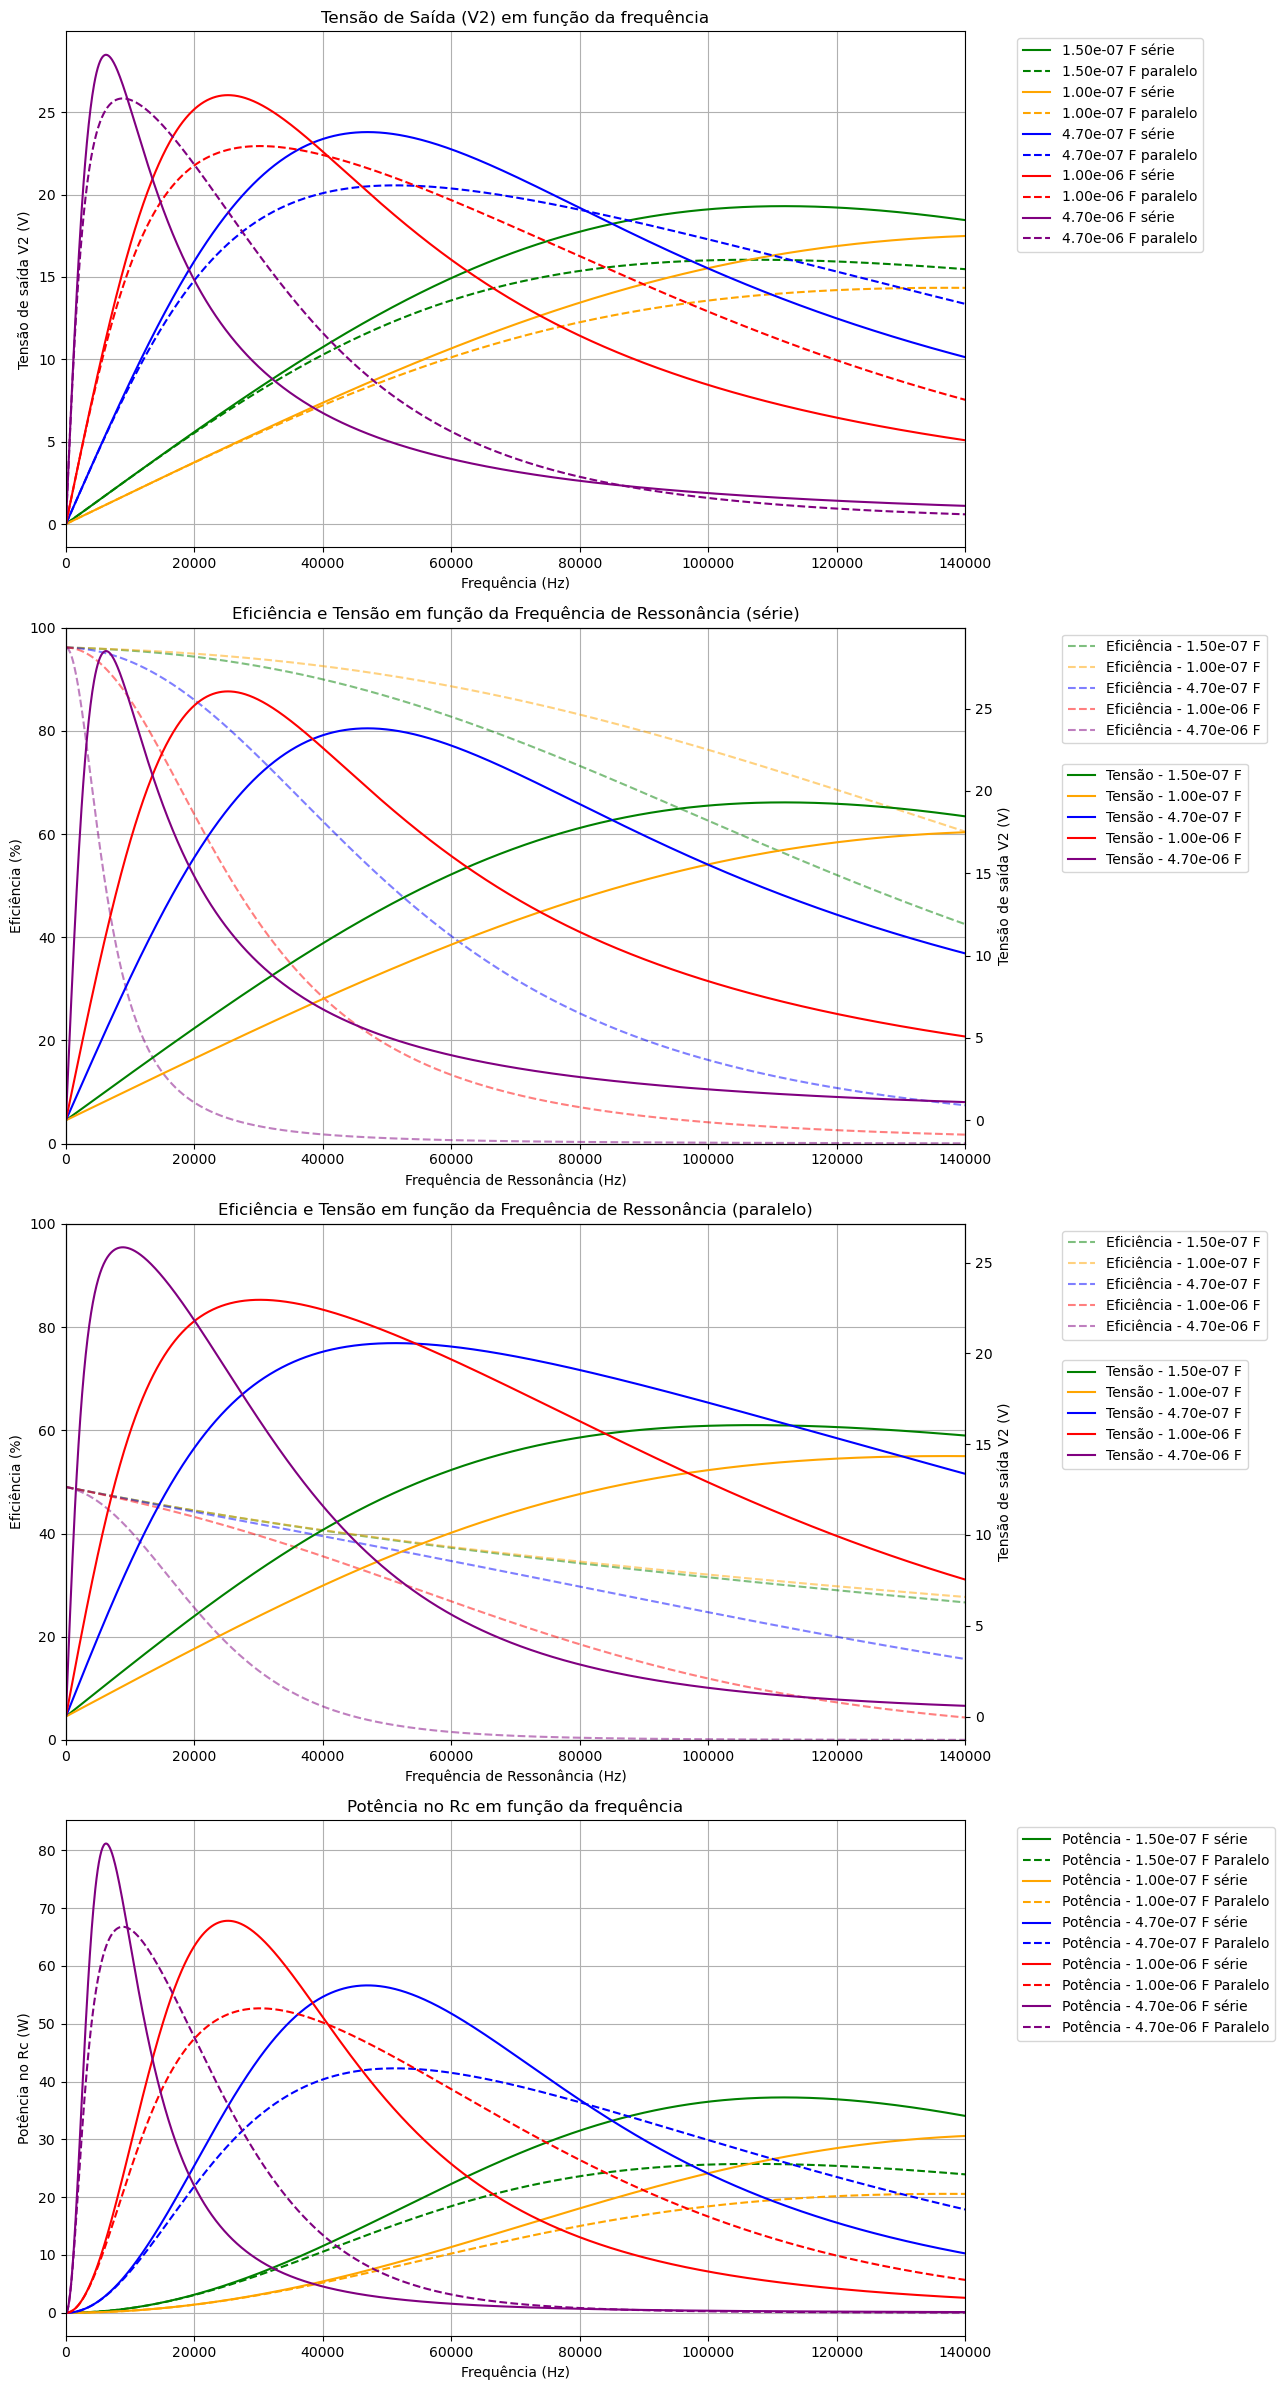

In [861]:
# Definição do estilo dos gráficos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 24))
cores = ['g', 'orange', 'b', 'r', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'lime']
linestyles = ['-', '--','-.']

ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()

# Loop para calcular e plotar os gráficos, considerando cada valor de C2
for i, C in enumerate(valores_c2):
    V_serie = []
    V_paralelo = []
    ef_serie = []
    ef_paralelo = []
    P_res_serie = []
    P_res_paralelo = []
    
    # Loop considerando cada valor de frequencia
    for freq in frequencias:
        #calculo dos componentes
        L1 = indutancia_ressonante(freq, C)
        L2 = indutancia_ressonante(freq, C)
        R1, R2 = R_pelicular(Rdc, freq)
        ZC1, ZL1, ZR1 = impedancia(R1, C, L1, freq)
        ZC2, ZL2, ZR2 = impedancia(R2, C, L2, freq)
        ZM = impedancia_ZM(L1, L2, K, freq)
        
        # Calcular para paralelo
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_paralelo.append(V2)
        ef_paralelo.append(eficiencia)
        P_res_paralelo.append(P_res)
        
        # Calcular para série
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_serie.append(V2)
        ef_serie.append(eficiencia)
        P_res_serie.append(P_res)
    
    # Plotar tensão série e paralelo no primeiro gráfico (ax1)
    ax1.plot(frequencias, V_serie, label=f'{C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax1.plot(frequencias, V_paralelo, label=f'{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[1]) 

    # Plotar eficiência de serie no segundo gráfico (ax2)
    ax2.plot(frequencias, ef_serie, label=f'Eficiência - {C:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax2_twin.plot(frequencias, V_serie, label=f'Tensão - {C:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    # Plotar eficiência de paralelo no terceiro gráfico (ax3)
    ax3.plot(frequencias, ef_paralelo, label=f'Eficiência - {C:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax3_twin.plot(frequencias, V_paralelo, label=f'Tensão - {C:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    #plotando potencia
    ax4.plot(frequencias, P_res_serie, label=f'Potência - {C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax4.plot(frequencias, P_res_paralelo, label=f'Potência - {C:.2e} F Paralelo', color=cores[i], linestyle=linestyles[1])

# Configurações do gráfico de tensões (ax1)
ax1.set_title("Tensão de Saída (V2) em função da frequência")
ax1.set_xlabel("Frequência (Hz)")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 140e3)  # Limite dos valores de frequêcia é até 100kHz
ax1.grid(True)

# Configurações do gráfico de eficiência (ax2)
ax2.set_title("Eficiência e Tensão em função da Frequência de Ressonância (série)")
ax2.set_xlabel("Frequência de Ressonância (Hz)")
ax2.set_ylabel("Eficiência (%)")
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax2.set_xlim(0, 140e3)
ax2.set_ylim(0, 100)
ax2.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax2
ax2_twin.set_ylabel("Tensão de saída V2 (V)")
ax2_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Configurações do gráfico de eficiência (ax3)
ax3.set_title("Eficiência e Tensão em função da Frequência de Ressonância (paralelo)")
ax3.set_xlabel("Frequência de Ressonância (Hz)")
ax3.set_ylabel("Eficiência (%)")
ax3.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax3.set_xlim(0, 140e3)
ax3.set_ylim(0, 100)
ax3.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax3
ax3_twin.set_ylabel("Tensão de saída V2 (V)")
ax3_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

ax4.set_title("Potência no Rc em função da frequência")
ax4.set_xlabel("Frequência (Hz)")
ax4.set_ylabel("Potência no Rc (W)")
ax4.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax4.set_xlim(0, 140e3)
ax4.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()


> Análise dos gráficos

Para decidir a melhor configuração e os valores de capacitância a serem utilizados no circuito, o último gráfico ("Potência no Rc em função da frequência") fornece uma melhor análise sobre a potência desejada em relação a frequência. É relevante para o projeto que a curva de potência possua um pico alto, mas que não varie muito em função de pequenas variações de frequência. Desse modo, dois capacitores chamam atenção: 1 μF e 0.47 μF.

Para esses capacitores, as curvas se mostram mais estáveis próximo ao pico quando comparadas aos demais capacitores.

Assim, mostra-se necessário realizar uma nova simulação comparando a eficiência e a potência para esses dois capacitores.

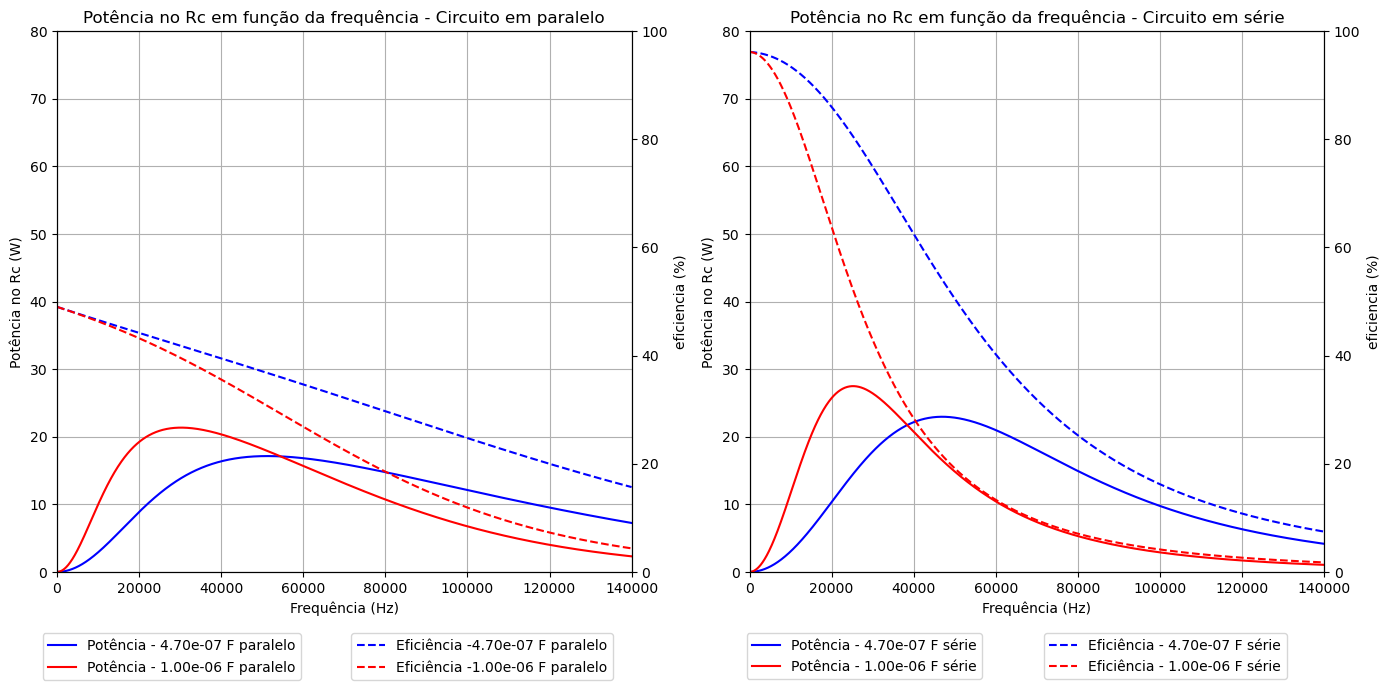

In [862]:
# Definição do estilo dos gráficos
C2_relevanes = [0.47e-6, 1e-6] #valores de capacitância para C2 relevantes para utilização no projeto
Uf = 12*(2/pi)    # Tensão de entrada (V1) ajustada para onda quadrada


fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 7))
cores = ['b', 'r', ]
linestyles = ['-', '--','-.']

ax5_twin = ax5.twinx()
ax6_twin = ax6.twinx()

# Loop para calcular e plotar os gráficos, considerando cada valor de C2
for i, C in enumerate(C2_relevanes):
    ef_serie = []
    ef_paralelo = []
    P_res_serie = []
    P_res_paralelo = []
    
    # Loop considerando cada valor de frequencia
    for freq in frequencias:
        #calculo dos componentes
        L1 = indutancia_ressonante(freq, C)
        L2 = indutancia_ressonante(freq, C)
        R1, R2 = R_pelicular(Rdc, freq)
        ZC1, ZL1, ZR1 = impedancia(R1, C, L1, freq)
        ZC2, ZL2, ZR2 = impedancia(R2, C, L2, freq)
        ZM = impedancia_ZM(L1, L2, K, freq)
        
        # Calcular para paralelo
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_paralelo.append(V2)
        ef_paralelo.append(eficiencia)
        P_res_paralelo.append(P_res)
        if abs(freq - 50000) < 50:
            eficiencia_50k = eficiencia
            P_res_50k = P_res
        
        # Calcular para série
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_serie.append(V2)
        ef_serie.append(eficiencia)
        P_res_serie.append(P_res)
        
        
    
    #plotando potencia e eficiencia do circuito em paralelo
    ax5.plot(frequencias, P_res_paralelo, label=f'Potência - {C:.2e} F paralelo', color=cores[i], linestyle=linestyles[0])
    ax5_twin.plot(frequencias, ef_paralelo, label=f'Eficiência -{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[1])
    
    #plotando potencia e eficiencia do circuito em série
    ax6.plot(frequencias, P_res_serie, label=f'Potência - {C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax6_twin.plot(frequencias, ef_serie, label=f'Eficiência - {C:.2e} F série', color=cores[i], linestyle=linestyles[1])
    

ax5.set_title("Potência no Rc em função da frequência - Circuito em paralelo")
ax5.set_xlabel("Frequência (Hz)")
ax5.set_ylabel("Potência no Rc (W)")
ax5.legend(loc= "upper center", bbox_to_anchor=(0.2, -0.1))
ax5.set_xlim(0, 140e3)
ax5.grid(True)

ax5_twin.set_ylabel("eficiencia (%)")
ax5_twin.legend(loc="upper left", bbox_to_anchor=(0.5, -0.1))  # Legenda do twin

ax6.set_title("Potência no Rc em função da frequência - Circuito em série")
ax6.set_xlabel("Frequência (Hz)")
ax6.set_ylabel("Potência no Rc (W)")
ax6.legend(loc= "upper center", bbox_to_anchor=(0.2, -0.1))
ax6.set_xlim(0, 140e3)
ax6.grid(True)

ax6_twin.set_ylabel("eficiencia (%)")
ax6_twin.legend(loc="upper left", bbox_to_anchor=(0.5, -0.1))  # Legenda do twin

# Define os limites dos eixos de potência e eficiência com a mesma escala
ax5.set_ylim(0,80)
ax6.set_ylim(0,80)
ax5_twin.set_ylim(0,100)
ax6_twin.set_ylim(0,100)


# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

##### 1.3 Conclusões da simulação

Comparando os dois circuitos, embora a o circuito em série possua tanto a eficiência quanto a potência atingindo valores mais altos, ambas variam mais acentuadamente com pequenas variações de frequência para os dois capacitores. Pensando na estabilidade do circuito, foi escolhido tanto o circuito quanto o capacitor que conferem maior estabilidade ao sistema. Desse modo, o capacitor escolhido foi o de 0.47 μF, configurado em paralelo com a carga.

A frequência adotada, por sua vez, foi a frequência próximo ao pico de maior potência no circuito em paralelo, isto é, aproximadamente 50 kHz.


> Valores adotados:

- C = 0.47 μF

- f = 50 kHz

- Circuito 1 - Capacitor em paralelo com a carga

# 2. Definição dos parâmetros reais

Além de escolher a configuração do circuito e o valor de capacitância, é necessário definir os valores de indutância das bobinas a serem construídas. Para isso, pode-se utilizar as funções já definidas para calcular a indutância ressonante.



 >Encontrando L

In [863]:
C = 4.7e-7
f = 50e3

L1 = indutancia_ressonante(f, C)
L2 = indutancia_ressonante(f, C)
L1_base = "{:.2e}".format(L1).split("e")[0]
L2_base = "{:.2e}".format(L2).split("e")[0]
L1_base = float(L1_base)*10
L2_base = float(L2_base)*10

print(f'Os valores de indutância obtidos são: L1 = {L1_base} μH e L2 = {L2_base} μH')

Os valores de indutância obtidos são: L1 = 21.6 μH e L2 = 21.6 μH


Sabendo que cada bobina deve ter 21.6 μH de indutância, foram construídas duas bobinas idênticas em laboratório. Os valores reais de indutância e resistência obtidos foram:

- L1 = 25.10 μH
- L2 = 25.67 μH
- R1 = 0.15 Ohm 
- R2 = 0.17 Ohm 

# 3. Variação da tensão em função da carga e do coeficiente de acoplamento

Agora com os dados reais do circuito, é necessário ajustar os valores da simulação afim de obter dados sobre como a tensão irá variar de acordo com a carga e o coeficiente de acoplamento do sistema. 



In [864]:
#Declaração dos componentes reais
C = 4.7e-7
f = 50e3
Rdc1 = 0.15
Rdc2 = 0.16
L1 = 25.10e-6
L2 = 25.67e-6
R1, _ = R_pelicular(Rdc1, f)
R2, _ = R_pelicular(Rdc2, f)
Uf = 12 * (2/pi)


##### 3.1 Definição do Coeficiente de Acoplamento 

Pode-se analisar como a carga irá influenciar na variação da tensão em função do coeficiente de acoplamento

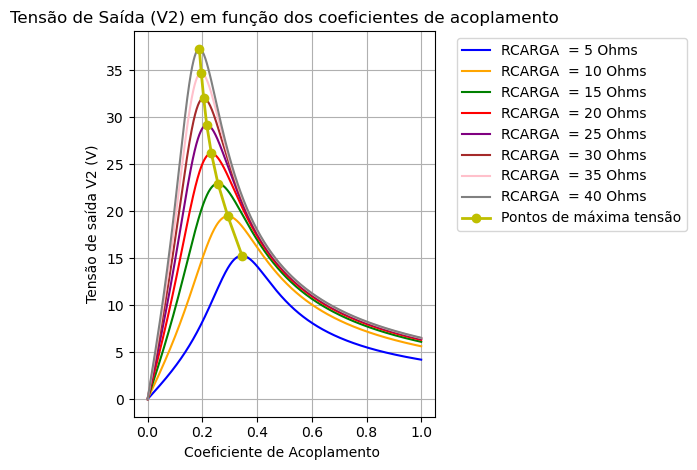

In [865]:
#configuração do gráfico
fig, ax1 = plt.subplots()

i = 0 
cores = [
    'blue',    # R carga = 5 Ω
    'orange',  # R carga = 10 Ω
    'green',   # R carga = 15 Ω
    'red',     # R carga = 20 Ω
    'purple',  # R carga = 25 Ω
    'brown',   # R carga = 30 Ω
    'pink',    # R carga = 35 Ω
    'gray',    # R carga = 40 Ω
    'yellow',  # Pontos de máxima tensão
]

#Declaração de Parâmetros 
resistencias = np.arange(5 , 45 , 5)
coeficientes = np.arange(0 , 1 , 0.001)

#valores de impedancias
ZC1, ZL1, ZR1 = impedancia(R1, C, L1, f)
ZC2, ZL2, ZR2 = impedancia(R2, C, L2, f)

v_max = []
k_max = []
pot_max = []

i = 0 

for resistencia in resistencias: 
    
    tensoes = []
    potencias = []
    
    for k in coeficientes: 
        ZM = impedancia_ZM(L1 , L2 , k , f)
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, resistencia, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        tensoes.append(V2)
        potencias.append(P_res)
    max_tensao = max(tensoes)
    max_pot = potencias[tensoes.index(max_tensao)]
    max_k = coeficientes[tensoes.index(max_tensao)]
    
    v_max.append(max(tensoes))
    k_max.append(max_k)
    pot_max.append(max_pot)
    ax1.plot(coeficientes, tensoes, label=f'RCARGA  = {resistencia} Ohms', color=cores[i], linestyle=linestyles[0]) 
    
    i += 1     

ax1.plot(k_max, v_max, label='Pontos de máxima tensão', color='#BFBF00', marker='o', linestyle='-', linewidth=2)
ax1.set_title("Tensão de Saída (V2) em função dos coeficientes de acoplamento")
ax1.set_xlabel("Coeficiente de Acoplamento ")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

Do gráfico, nota-se que quanto maior a carga, maior será a tensão na saída.

Das especificações do produto, o fabricante indica que a potência nominal do aparelho é de 10W. Devido a geometria do dispositivo optou-se por utilizar a mesma resistência que o fabricante adotou para a construção do produto, que quando medida com o multimetro apontou aproximadamente 1300 ohms.

Se repetirmos os cálculos usados apra gerar o gráfico anterior, mas apenas com a resistência utilizada pelo fabricante, é possível obter a curva que relaciona a tensão na saída com o coeficiente de acoplamento. 

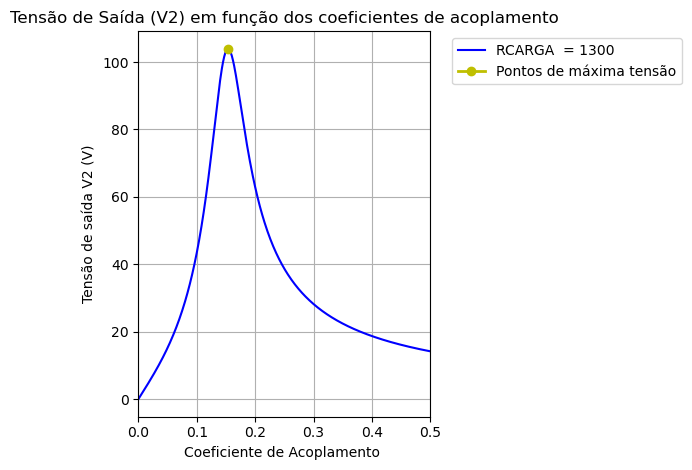

In [866]:
#Declaração de Parâmetros 
resistencia_real = 1300

fig, ax1 = plt.subplots()

coeficientes = np.arange(0 , 1 , 0.001)

tensoes = []
potencias = []

for k in coeficientes: 
    ZM = impedancia_ZM(L1 , L2 , k , f)
    i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, resistencia_real, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
    tensoes.append(V2)
    potencias.append(P_res)

max_tensao = max(tensoes)
max_pot = potencias[tensoes.index(max_tensao)]
max_k = coeficientes[tensoes.index(max_tensao)]

ax1.plot(coeficientes, tensoes, label=f'RCARGA  = {resistencia_real}', color=cores[0], linestyle=linestyles[0])    
ax1.plot(max_k, max_tensao, label='Pontos de máxima tensão', color='#BFBF00', marker='o', linestyle='-', linewidth=2)
ax1.set_title("Tensão de Saída (V2) em função dos coeficientes de acoplamento")
ax1.set_xlabel("Coeficiente de Acoplamento ")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 0.5)

ax1.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

In [867]:
# Valor de V2 máximo:
print(f'Valor de V2 máximo: {max_tensao:.2f} V')
# Valor do K para a tensão máxima
print(f'Valor de K para a tensão máxima: {max_k}')


Valor de V2 máximo: 103.90 V
Valor de K para a tensão máxima: 0.154


Portanto, a maior tensão de saída para o circuito configurado é 103.9V e ocorre para um coeficiente de acoplamento igual a 0.15.

In [868]:
V2_real = 98.5

# Encontrar o índice do valor mais próximo de V2_real na lista tensoes
indice_mais_proximo = min(range(len(tensoes)), key=lambda i: abs(tensoes[i] - V2_real))
k_real = coeficientes[indice_mais_proximo]

print(f'Valor de K para a tensão real mais próxima: {k_real}')


Valor de K para a tensão real mais próxima: 0.164


> Conclusão

Após a montagem do circuito, com as bobinas ajustadas na posição final, a tensão obtida na saída do secundário foi de aproximadamente 98.5 volts. 
Para essa tensão, o K encontrado através da simulação é de 0.164. Portanto, o valor do coeficiente de acoplamento desse circuito é 0.164.

# 4. Conclusão 

In [869]:
#Dados experimentais
#potência real na carga
print("*"*10, "Dados experimentais", "*"*10)
Pot2 = V2_real**2 / resistencia_real
print(f'Potência aproveitada no secundário: {Pot2:.2f} W')
#potencia real no primário
Pot1 = 12*2
#eficiencia do circuito:
eficiencia = 100*Pot2/Pot1
print(f'Eficiência do circuito: {eficiencia:.2f} %')


********** Dados experimentais **********
Potência aproveitada no secundário: 7.46 W
Eficiência do circuito: 31.10 %


Com o produto finalizado, foi possível calcular a potência consumida e a eficiência do projeto. Os seguintes valores foram obtidos.

- A potência consumida pela carga foi de 7.46 W
- A eficiência do circuito foi de 31.10%


# 5. Comentário adicional

Para indicar o funcionamento do circuito, é conveniente adicionar um LED indicador. Para isso, um Led em série com um resistor de 2000 ohms foi conectado, em paralelo, aos terminais da carga. Os novos componentes não impactaram de maneira significativa o funcionamento do circuito, e o novo esquema pode ser visualizado abaixo.  

<div style="text-align: center;">
    <img src="circuitoFinal.png"/>
    <p>Circuito Final.</p>
</div>